## Inception V1 Example
In this notebook we will go through the process of converting the Inception V1 model to a Neural Network Classifier CoreML model that directly predicts the class label of the input image. We will highlight the importance of setting the image preprocessing parameters correclty to get the right results. 
Lets get started!

Lets first download the inception V1 frozen TF graph (the .pb file)

In [1]:
# Download the model and class label package
import os
import urllib
import tarfile
def download_file_and_unzip(url, dir_path='.'):
    """Download the frozen TensorFlow model and unzip it.
    url - The URL address of the frozen file
    dir_path - local directory
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    k = url.rfind('/')
    fname = url[k+1:]
    fpath = os.path.join(dir_path, fname)

    if not os.path.exists(fpath):
        urllib.urlretrieve(url, fpath)
    tar = tarfile.open(fpath)
    tar.extractall(dir_path)
    tar.close()

inception_v1_url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception_v1_2016_08_28_frozen.pb.tar.gz'
download_file_and_unzip(inception_v1_url)

For conversion to CoreML, we need to find the input and output tensor names in the TF graph. This will also be required to run the TF graph for numerical accuracy check. Lets load the TF graph def and try to find the names

In [2]:
# Load the TF graph definition
import tensorflow as tf
tf_model_path = './inception_v1_2016_08_28_frozen.pb'
with open(tf_model_path, 'rb') as f:
    serialized = f.read()
tf.reset_default_graph()
original_gdef = tf.GraphDef()
original_gdef.ParseFromString(serialized)

# Lets get some details about a few ops in the beginning and the end of the graph
with tf.Graph().as_default() as g:
    tf.import_graph_def(original_gdef, name='')
    ops = g.get_operations()
    N = len(ops)
    for i in [0,1,2,N-3,N-2,N-1]:
        print('\n\nop id {} : op type: "{}"'.format(str(i), ops[i].type));
        print('input(s):'),
        for x in ops[i].inputs:
            print("name = {}, shape: {}, ".format(x.name, x.get_shape())),
        print('\noutput(s):'),
        for x in ops[i].outputs:
            print("name = {}, shape: {},".format(x.name, x.get_shape())),           



op id 0 : op type: "Placeholder"
input(s): 
output(s): name = input:0, shape: (1, 224, 224, 3), 

op id 1 : op type: "Const"
input(s): 
output(s): name = InceptionV1/Conv2d_1a_7x7/weights:0, shape: (7, 7, 3, 64), 

op id 2 : op type: "Identity"
input(s): name = InceptionV1/Conv2d_1a_7x7/weights:0, shape: (7, 7, 3, 64),  
output(s): name = InceptionV1/Conv2d_1a_7x7/weights/read:0, shape: (7, 7, 3, 64), 

op id 1012 : op type: "Softmax"
input(s): name = InceptionV1/Logits/Predictions/Reshape:0, shape: (1, 1001),  
output(s): name = InceptionV1/Logits/Predictions/Softmax:0, shape: (1, 1001), 

op id 1013 : op type: "Const"
input(s): 
output(s): name = InceptionV1/Logits/Predictions/Shape:0, shape: (2,), 

op id 1014 : op type: "Reshape"
input(s): name = InceptionV1/Logits/Predictions/Softmax:0, shape: (1, 1001),  name = InceptionV1/Logits/Predictions/Shape:0, shape: (2,),  
output(s): name = InceptionV1/Logits/Predictions/Reshape_1:0, shape: (1, 1001),


The output of the Placeholder op is the input ("input:0") and the output of the Softmax op towards the end of the graph is the output ("InceptionV1/Logits/Predictions/Softmax:0"). Lets convert to mlmodel now.

In [3]:
import tfcoreml
# Supply a dictionary of input tensors' name and shape (with batch axis)
input_tensor_shapes = {"input:0":[1,224,224,3]} # batch size is 1
#providing the image_input_names argument converts the input into an image for CoreML
image_input_name = ['input:0']
# Output CoreML model path
coreml_model_file = './inception_v1.mlmodel'
# The TF model's ouput tensor name
output_tensor_names = ['InceptionV1/Logits/Predictions/Softmax:0']
# class label file: providing this will make a "Classifier" CoreML model
class_labels = 'imagenet_slim_labels.txt'

# Call the converter. This may take a while
coreml_model = tfcoreml.convert(
        tf_model_path=tf_model_path,
        mlmodel_path=coreml_model_file,
        input_name_shape_dict=input_tensor_shapes,
        output_feature_names=output_tensor_names,
        image_input_names = image_input_name,
        class_labels = class_labels)


Automatic shape interpretation succeeded for input blob input:0
4/1015: Converting op name: InceptionV1/Logits/Conv2d_0c_1x1/biases/read ( type:  Identity )
6/1015: Converting op name: InceptionV1/Logits/Conv2d_0c_1x1/weights/read ( type:  Identity )
10/1015: Converting op name: InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance/read ( type:  Identity )
11/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/batchnorm/add ( type:  Add )
12/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
14/1015: Converting op name: InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean/read ( type:  Identity )
15/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/batchnorm/mul_1 ( type:  Mul )
17/1015: Converting op name: InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/beta/read ( type:  Identity )
18/1015: Conve

388/1015: Converting op name: InceptionV1/Mixed_4d/Branch_1/Conv2d_0a_1x1/weights/read ( type:  Identity )
391/1015: Converting op name: InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
392/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add ( type:  Add )
393/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
395/1015: Converting op name: InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
396/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/mul_1 ( type:  Mul )
398/1015: Converting op name: InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
399/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/sub ( type:  Sub )
401/1015: Converting op nam

607/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/mul_1 ( type:  Mul )
609/1015: Converting op name: InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/BatchNorm/beta/read ( type:  Identity )
610/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/sub ( type:  Sub )
612/1015: Converting op name: InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/weights/read ( type:  Identity )
615/1015: Converting op name: InceptionV1/Mixed_3c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
616/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0a_1x1/BatchNorm/batchnorm/add ( type:  Add )
617/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0a_1x1/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
619/1015: Converting op name: InceptionV1/Mixed_3c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
620/1015: Converting op nam

728/1015: Converting op name: InceptionV1/InceptionV1/Conv2d_2c_3x3/BatchNorm/batchnorm/sub ( type:  Sub )
730/1015: Converting op name: InceptionV1/Conv2d_2c_3x3/weights/read ( type:  Identity )
733/1015: Converting op name: InceptionV1/Conv2d_2b_1x1/BatchNorm/moving_variance/read ( type:  Identity )
734/1015: Converting op name: InceptionV1/InceptionV1/Conv2d_2b_1x1/BatchNorm/batchnorm/add ( type:  Add )
735/1015: Converting op name: InceptionV1/InceptionV1/Conv2d_2b_1x1/BatchNorm/batchnorm/Rsqrt ( type:  Rsqrt )
737/1015: Converting op name: InceptionV1/Conv2d_2b_1x1/BatchNorm/moving_mean/read ( type:  Identity )
738/1015: Converting op name: InceptionV1/InceptionV1/Conv2d_2b_1x1/BatchNorm/batchnorm/mul_1 ( type:  Mul )
740/1015: Converting op name: InceptionV1/Conv2d_2b_1x1/BatchNorm/beta/read ( type:  Identity )
741/1015: Converting op name: InceptionV1/InceptionV1/Conv2d_2b_1x1/BatchNorm/batchnorm/sub ( type:  Sub )
743/1015: Converting op name: InceptionV1/Conv2d_2b_1x1/weights/

816/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/mul ( type:  Mul )
817/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/add_1 ( type:  Add )
818/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_1/Conv2d_0b_3x3/Relu ( type:  Relu )
819/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_0/Conv2d_0a_1x1/convolution ( type:  Conv2D )
820/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/mul ( type:  Mul )
821/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1 ( type:  Add )
822/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/Branch_0/Conv2d_0a_1x1/Relu ( type:  Relu )
823/1015: Converting op name: InceptionV1/InceptionV1/Mixed_3c/concat_v2 ( type:  ConcatV2 )
824/1015: Converting op name: InceptionV1/InceptionV1/MaxPool_4a_3x3/MaxP

895/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/mul ( type:  Mul )
896/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/add_1 ( type:  Add )
897/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_1/Conv2d_0b_3x3/Relu ( type:  Relu )
898/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/convolution ( type:  Conv2D )
899/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/mul ( type:  Mul )
900/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1 ( type:  Add )
901/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/Branch_0/Conv2d_0a_1x1/Relu ( type:  Relu )
902/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4d/concat_v2 ( type:  ConcatV2 )
903/1015: Converting op name: InceptionV1/InceptionV1/Mixed_4e/Branch_3/M

970/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/batchnorm/mul ( type:  Mul )
971/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1 ( type:  Add )
972/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0a_1x1/Relu ( type:  Relu )
973/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0b_3x3/convolution ( type:  Conv2D )
974/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/mul ( type:  Mul )
975/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0b_3x3/BatchNorm/batchnorm/add_1 ( type:  Add )
976/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_1/Conv2d_0b_3x3/Relu ( type:  Relu )
977/1015: Converting op name: InceptionV1/InceptionV1/Mixed_5b/Branch_0/Conv2d_0a_1x1/convolution ( type:  Conv2D )
978/1015: Converting op name: InceptionV1/Inceptio

Lets load an image for testing. We will get predictions on this image using the TF model and the corresponding mlmodel.

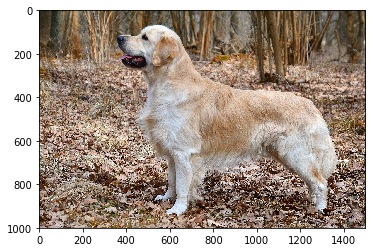

In [4]:
# Now we're ready to test out the CoreML model with a real image!
# Load an image
import numpy as np
import PIL
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
# This is an image of a golden retriever from Wikipedia
img_url = 'https://upload.wikimedia.org/wikipedia/commons/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg'
response = requests.get(img_url)
%matplotlib inline
img = PIL.Image.open(BytesIO(response.content))
imshow(np.asarray(img))

In [5]:
# for getting CoreML predictions we directly pass in the PIL image after resizing
import coremltools
img = img.resize([224,224], PIL.Image.ANTIALIAS)
coreml_inputs = {'input__0': img}
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)
coreml_pred_dict = coreml_output['InceptionV1__Logits__Predictions__Softmax__0']
coreml_predicted_class_label = coreml_output['classLabel']

#for getting TF predciton we get the numpy array of the image
img_np = np.array(img).astype(np.float32)
print 'image shape:', img_np.shape
print 'first few values: ', img_np.flatten()[0:4], 'max value: ', np.amax(img_np)
img_tf = np.expand_dims(img_np, axis = 0) #now shape is [1,224,224,3] as required by TF

# Evaluate TF and get the highest label 
tf_input_name = 'input:0'
tf_output_name = 'InceptionV1/Logits/Predictions/Softmax:0'
with tf.Session(graph = g) as sess:
    tf_out = sess.run(tf_output_name, 
                      feed_dict={tf_input_name: img_tf})
tf_out = tf_out.flatten()    
idx = np.argmax(tf_out)
label_file = 'imagenet_slim_labels.txt' 
with open(label_file) as f:
    labels = f.readlines()
    
#print preditions   
print('\n')
print("CoreML prediction class = {}, probabiltiy = {}".format(coreml_predicted_class_label,
                                            str(coreml_pred_dict[coreml_predicted_class_label])))  
print("TF prediction class = {}, probability = {}".format(labels[idx],
                                            str(tf_out[idx])))

image shape: (224, 224, 3)
first few values:  [ 39.  33.  18.  42.] max value:  255.0


CoreML prediction class = thatch, probabiltiy = 0.537294983864
TF prediction class = thatch
, probability = 0.537292


Both the predicitons match, this means that the conversion was correct. However, the class label seems incorrect. What could be the reason? The answer is that we did not preprocess the image correctly before passing it to the neural network!! This is always a crucial step when using neural networks on images.

How do we know what preprocessing to apply? This can be tricky to find sometimes. The approach is to find the source of the pre-trained model and check for the preprocessing that the author of the model used while training and evalaution. In this case, the TF model comes from the SLIM library so we find the preprocessing steps [here](https://github.com/tensorflow/models/blob/edb6ed22a801665946c63d650ab9a0b23d98e1b1/research/slim/preprocessing/inception_preprocessing.py#L243)

We see that the image pixels have to be scaled to lie in the interval [-1,1]. Lets do that and get the TF predicitons again! 

In [6]:
img_tf = (2.0/255.0) * img_tf - 1
with tf.Session(graph = g) as sess:
    tf_out = sess.run(tf_output_name, 
                      feed_dict={tf_input_name: img_tf})
tf_out = tf_out.flatten()    
idx = np.argmax(tf_out)
print("TF prediction class = {}, probability = {}".format(labels[idx],
                                            str(tf_out[idx])))

TF prediction class = English setter
, probability = 0.301506


Much better now! The model is predciting a dog as the highest class. 

What about CoreML? CoreML automatically handles the image preprocessing, when the input is of type image, so we do not have to change the input that we were passing in earlier. For the mlmodel we converted, lets see what the image biases and scale have been set to

In [8]:
# Get image pre-processing parameters of a saved CoreML model
from coremltools.proto import FeatureTypes_pb2 as _FeatureTypes_pb2


spec = coremltools.models.utils.load_spec(coreml_model_file)
if spec.WhichOneof('Type') == 'neuralNetworkClassifier':
  nn = spec.neuralNetworkClassifier
if spec.WhichOneof('Type') == 'neuralNetwork':
  nn = spec.neuralNetwork  
if spec.WhichOneof('Type') == 'neuralNetworkRegressor':
  nn = spec.neuralNetworkRegressor

preprocessing = nn.preprocessing[0].scaler
print 'channel scale: ', preprocessing.channelScale
print 'blue bias: ', preprocessing.blueBias
print 'green bias: ', preprocessing.greenBias
print 'red bias: ', preprocessing.redBias

inp = spec.description.input[0]
if inp.type.WhichOneof('Type') == 'imageType':
  colorspace = _FeatureTypes_pb2.ImageFeatureType.ColorSpace.Name(inp.type.imageType.colorSpace)
  print 'colorspace: ', colorspace

channel scale:  1.0
blue bias:  0.0
green bias:  0.0
red bias:  0.0
colorspace:  RGB


As suspected, they are not correct. Lets convert the model again and set them correctly this time. Note that the channel scale is multiplied first and then the bias is added. 

In [ ]:
# Call the converter. This may take a while
coreml_model = tfcoreml.convert(
        tf_model_path=tf_model_path,
        mlmodel_path=coreml_model_file,
        input_name_shape_dict=input_tensor_shapes,
        output_feature_names=output_tensor_names,
        image_input_names = image_input_name,
        class_labels = class_labels,
        red_bias = -1,
        green_bias = -1,
        blue_bias = -1,
        image_scale = 2.0/255.0)

In [ ]:
# Call CoreML predcit again
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)
coreml_pred_dict = coreml_output['InceptionV1__Logits__Predictions__Softmax__0']
coreml_predicted_class_label = coreml_output['classLabel']
print("CoreML prediction class = {}, probabiltiy = {}".format(coreml_predicted_class_label,
                                            str(coreml_pred_dict[coreml_predicted_class_label])))

Yes, now its matching the TF output and is correct!!

Note that predcitions with the default CoreML predict call (when the flag useCPUOnly=True is skipped) may vary slighlty since it uses a lower precision optimized path that runs faster. 